In [1]:
import pandas as pd
import os
import os.path as op
import h5py
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from dtw import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from scipy.stats.mstats import winsorize
from tqdm.notebook import trange, tqdm
from scipy.ndimage import gaussian_filter1d
from mne.stats import permutation_cluster_test, permutation_cluster_1samp_test, ttest_1samp_no_p
from functools import partial
from matplotlib import colors
from mne.io import read_epochs_eeglab

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
pipeline='NEARICA'
ages=['9m','12m','adult']

cluster_chans={
    'C': ['E16', 'E20', 'E21', 'E22','E41', 'E49', 'E50', 'E51'],
    'P': ['E26', 'E27','E28', 'E31', 'E40','E42', 'E45', 'E46']
}

def load_bursts(pipeline, age, clus_name):
    bursts = {
        'age': [],
        'subject': [],
        'chan': [],
        'cluster': [],
        'condition': [],
        'epoch': [],
        'fwhm_freq': [],
        'fwhm_time': [],
        'peak_adjustment': [],
        'peak_amp_base': [],
        'peak_amp_iter': [],
        'peak_freq': [],
        'peak_time': [],
        'polarity': [],
        'trial': [],
        'waveform': [],        
        'waveform_times': []
    }

    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')
    for subject in subjects['participant_id']:
        print('loading {}'.format(subject))
        fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,subject,'processed_data/processed_{}_bursts.mat'.format(clus_name))
        if os.path.exists(fname):
            with h5py.File(fname, 'r') as f:
                bursts['age'].extend([age for x in list(f['bursts']['trial'])])
                bursts['subject'].extend([subject for x in list(f['bursts']['trial'])])
                bursts['chan'].extend(list(np.squeeze(f['bursts']['chan'][:])))
                bursts['cluster'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['cluster'][:])])
                bursts['condition'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['condition'][:])])
                bursts['epoch'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['epoch'][:])])
                bursts['fwhm_freq'].extend(list(np.squeeze(f['bursts']['fwhm_freq'][:])))
                bursts['fwhm_time'].extend(list(np.squeeze(f['bursts']['fwhm_time'][:])))
                bursts['peak_adjustment'].extend(list(np.squeeze(f['bursts']['peak_adjustment'][:])))
                bursts['peak_amp_base'].extend(list(np.squeeze(f['bursts']['peak_amp_base'][:])))
                bursts['peak_amp_iter'].extend(list(np.squeeze(f['bursts']['peak_amp_iter'][:])))
                bursts['peak_freq'].extend(list(np.squeeze(f['bursts']['peak_freq'][:])))
                bursts['peak_time'].extend(list(np.squeeze(f['bursts']['peak_time'][:])))
                bursts['polarity'].extend(list(np.squeeze(f['bursts']['polarity'][:])))
                bursts['trial'].extend(list(np.squeeze(f['bursts']['trial'][:])))
                for i in range(f['bursts']['waveform'][:,:].shape[1]):
                    bursts['waveform'].append(f['bursts']['waveform'][:,i])
                bursts['waveform_times']=f['bursts']['waveform_times'][:]
                
    bursts['age']=np.array(bursts['age'])
    bursts['subject']=np.array(bursts['subject'])
    bursts['chan']=np.array(bursts['chan'])
    bursts['cluster']=np.array(bursts['cluster'])
    bursts['condition']=np.array(bursts['condition'])
    bursts['epoch']=np.array(bursts['epoch'])
    bursts['fwhm_freq']=np.array(bursts['fwhm_freq'])
    bursts['fwhm_time']=np.array(bursts['fwhm_time'])
    bursts['peak_adjustment']=np.array(bursts['peak_adjustment'])
    bursts['peak_amp_base']=np.array(bursts['peak_amp_base'])
    bursts['peak_amp_iter']=np.array(bursts['peak_amp_iter'])
    bursts['peak_freq']=np.array(bursts['peak_freq'])
    bursts['peak_time']=np.array(bursts['peak_time'])
    bursts['polarity']=np.array(bursts['polarity'])
    bursts['trial']=np.array(bursts['trial'])
    bursts['waveform']=np.array(bursts['waveform'])
    bursts['waveform_times']=np.array(bursts['waveform_times'])
    
    return bursts

In [3]:
def filter_bursts(bursts, idx):
    
    filtered_bursts={
        'age': bursts['age'][idx],
        'subject': bursts['subject'][idx],
        'chan': bursts['chan'][idx],
        'cluster': bursts['cluster'][idx],
        'condition': bursts['condition'][idx],
        'epoch': bursts['epoch'][idx],
        'fwhm_freq': bursts['fwhm_freq'][idx],
        'fwhm_time': bursts['fwhm_time'][idx],
        'peak_adjustment': bursts['peak_adjustment'][idx],
        'peak_amp_base': bursts['peak_amp_base'][idx],
        'peak_amp_iter': bursts['peak_amp_iter'][idx],
        'peak_freq': bursts['peak_freq'][idx],
        'peak_time': bursts['peak_time'][idx],
        'polarity': bursts['polarity'][idx],
        'trial': bursts['trial'][idx],
        'waveform': bursts['waveform'][idx,:],
        'waveform_times': bursts['waveform_times']
    }

    return filtered_bursts

In [4]:
def shuffle_array(array):
    X_array = array.copy()
    rows, columns = array.shape
    for col in range(columns):
        ixes = np.arange(0,rows)
        np.random.shuffle(ixes)
        X_array[:,col] = X_array[:,col][ixes]
    return X_array

def shuffle_array_range(array, ranges):
    X_array = []
    for x1, x2 in ranges:
        X = wvf[:,x1:x2]
        np.random.shuffle(X)
        X_array.append(X)
    return np.hstack(X_array)

def get_num_components(waveforms):
    # robust scaling
    waveforms_scaled = RobustScaler().fit_transform(waveforms)

    # main PCA fitting
    pca_full = PCA(n_components=50)
    pcs_full = pca_full.fit_transform(waveforms_scaled)
    var_full = pca_full.explained_variance_ratio_ 

    # robustness of pca components
    no_of_iter = 100
    pca_vars = []
    for i in range(no_of_iter):
        shuffled_wvf = shuffle_array(waveforms_scaled)

        pca_shuff = PCA(n_components=50)
        pca_shuff.fit(shuffled_wvf)
        pca_vars.append(pca_shuff.explained_variance_ratio_)        
    del shuffled_wvf
    pca_vars=np.array(pca_vars)

    # getting the magic number
    results = np.sum(var_full>pca_vars, axis=0) / no_of_iter
    PCS_to_analyse = len(np.where(results > 0.95)[0])
    return PCS_to_analyse


In [5]:
c_bursts_9m=load_bursts(pipeline, '9m', 'C')
p_bursts_9m=load_bursts(pipeline, '9m', 'P')

loading sub-010
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-036
loading sub-037
loading sub-038
loading sub-041
loading sub-042
loading sub-043
loading sub-044
loading sub-010
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-036
loading sub-037
loading sub-038
loading sub-041
loading sub-042
loading sub-043
loading sub-044


In [6]:
c_bursts_12m=load_bursts(pipeline, '12m', 'C')
p_bursts_12m=load_bursts(pipeline, '12m', 'P')

loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading 

In [7]:
c_bursts_adult=load_bursts(pipeline, 'adult', 'C')
p_bursts_adult=load_bursts(pipeline, 'adult', 'P')

loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022


In [8]:
idx=np.where((np.abs(c_bursts_9m['peak_amp_base']-np.median(c_bursts_9m['peak_amp_base']))<2.5*np.std(c_bursts_9m['peak_amp_base'])))[0]
c_bursts_9m=filter_bursts(c_bursts_9m, idx)
idx=np.where((np.abs(p_bursts_9m['peak_amp_base']-np.median(p_bursts_9m['peak_amp_base']))<2.5*np.std(p_bursts_9m['peak_amp_base'])))[0]
p_bursts_9m=filter_bursts(p_bursts_9m, idx)

idx=np.where((np.abs(c_bursts_12m['peak_amp_base']-np.median(c_bursts_12m['peak_amp_base']))<2.5*np.std(c_bursts_12m['peak_amp_base'])))[0]
c_bursts_12m=filter_bursts(c_bursts_12m, idx)
idx=np.where((np.abs(p_bursts_12m['peak_amp_base']-np.median(p_bursts_12m['peak_amp_base']))<2.5*np.std(p_bursts_12m['peak_amp_base'])))[0]
p_bursts_12m=filter_bursts(p_bursts_12m, idx)

idx=np.where((np.abs(c_bursts_adult['peak_amp_base']-np.median(c_bursts_adult['peak_amp_base']))<2.5*np.std(c_bursts_adult['peak_amp_base'])))[0]
c_bursts_adult=filter_bursts(c_bursts_adult, idx)
idx=np.where((np.abs(p_bursts_adult['peak_amp_base']-np.median(p_bursts_adult['peak_amp_base']))<2.5*np.std(p_bursts_adult['peak_amp_base'])))[0]
p_bursts_adult=filter_bursts(p_bursts_adult, idx)

In [9]:
c_burst_times_9m=c_bursts_9m['waveform_times']
c_burst_times_12m=c_bursts_12m['waveform_times']
c_burst_times_adult=c_bursts_adult['waveform_times']
med_c_9m=np.percentile(c_bursts_9m['waveform'], 50, axis=0)
med_c_12m=np.percentile(c_bursts_12m['waveform'], 50, axis=0)
med_c_adult=np.percentile(c_bursts_adult['waveform'], 50, axis=0)
norm_c_adult=med_c_adult/np.max(med_c_adult)
norm_c_12m=med_c_12m/np.max(med_c_12m)
norm_c_9m=med_c_9m/np.max(med_c_9m)
alignment_c_9m=dtw(norm_c_9m, norm_c_adult, keep_internals=True, step_pattern=rabinerJuangStepPattern(5,"c"))
aligned_c_9m_idx=warp(alignment_c_9m,index_reference=False)
alignment_c_12m=dtw(norm_c_12m, norm_c_adult, keep_internals=True, step_pattern=rabinerJuangStepPattern(5,"c"))
aligned_c_12m_idx=warp(alignment_c_12m,index_reference=False)
aligned_c_9m_bursts=c_bursts_9m['waveform'][:,aligned_c_9m_idx]
aligned_c_12m_bursts=c_bursts_12m['waveform'][:,aligned_c_12m_idx]
aligned_c_adult_bursts=c_bursts_adult['waveform'][:,:-1]

p_burst_times_9m=p_bursts_9m['waveform_times']
p_burst_times_12m=p_bursts_12m['waveform_times']
p_burst_times_adult=p_bursts_adult['waveform_times']
med_p_9m=np.percentile(p_bursts_9m['waveform'], 50, axis=0)
med_p_12m=np.percentile(p_bursts_12m['waveform'], 50, axis=0)
med_p_adult=np.percentile(p_bursts_adult['waveform'], 50, axis=0)
norm_p_adult=med_p_adult/np.max(med_p_adult)
norm_p_12m=med_p_12m/np.max(med_p_12m)
norm_p_9m=med_p_9m/np.max(med_p_9m)
alignment_p_9m=dtw(norm_p_9m, norm_p_adult, keep_internals=True, step_pattern=rabinerJuangStepPattern(5,"c"))
aligned_p_9m_idx=warp(alignment_p_9m,index_reference=False)
alignment_p_12m=dtw(norm_p_12m, norm_p_adult, keep_internals=True, step_pattern=rabinerJuangStepPattern(5,"c"))
aligned_p_12m_idx=warp(alignment_p_12m,index_reference=False)
aligned_p_9m_bursts=p_bursts_9m['waveform'][:,aligned_p_9m_idx]
aligned_p_12m_bursts=p_bursts_12m['waveform'][:,aligned_p_12m_idx]
aligned_p_adult_bursts=p_bursts_adult['waveform'][:,:-1]

aligned_c_bursts=np.vstack([aligned_c_9m_bursts,aligned_c_12m_bursts,aligned_c_adult_bursts])
aligned_p_bursts=np.vstack([aligned_p_9m_bursts,aligned_p_12m_bursts,aligned_p_adult_bursts])

In [10]:
c_pca = PCA(n_components=20)
burst_std_c_9m=RobustScaler().fit_transform(aligned_c_9m_bursts)
burst_std_c_12m=RobustScaler().fit_transform(aligned_c_12m_bursts)
burst_std_c_adult=RobustScaler().fit_transform(aligned_c_adult_bursts)
burst_std_c=np.vstack([burst_std_c_9m, burst_std_c_12m, burst_std_c_adult])
c_pca=c_pca.fit(burst_std_c)
pcs_c_9m = c_pca.transform(burst_std_c_9m)
pcs_c_12m = c_pca.transform(burst_std_c_12m)
pcs_c_adult = c_pca.transform(burst_std_c_adult)

p_pca = PCA(n_components=20)
burst_std_p_9m=RobustScaler().fit_transform(aligned_p_9m_bursts)
burst_std_p_12m=RobustScaler().fit_transform(aligned_p_12m_bursts)
burst_std_p_adult=RobustScaler().fit_transform(aligned_p_adult_bursts)
burst_std_p=np.vstack([burst_std_p_9m, burst_std_p_12m, burst_std_p_adult])
p_pca=p_pca.fit(burst_std_p)
pcs_p_9m = p_pca.transform(burst_std_p_9m)
pcs_p_12m = p_pca.transform(burst_std_p_12m)
pcs_p_adult = p_pca.transform(burst_std_p_adult)

for p in range(20):
    pcs_c_9m[:,p]=winsorize(pcs_c_9m[:,p], limits=(.01, .01))   
    pcs_p_9m[:,p]=winsorize(pcs_p_9m[:,p], limits=(.01, .01))   
pca_components_c_9m = pd.DataFrame(pcs_c_9m)
pca_components_p_9m = pd.DataFrame(pcs_p_9m)
for p in range(20):
    pcs_c_12m[:,p]=winsorize(pcs_c_12m[:,p], limits=(.01, .01))   
    pcs_p_12m[:,p]=winsorize(pcs_p_12m[:,p], limits=(.01, .01))   
pca_components_c_12m = pd.DataFrame(pcs_c_12m)
pca_components_p_12m = pd.DataFrame(pcs_p_12m)
for p in range(20):
    pcs_c_adult[:,p]=winsorize(pcs_c_adult[:,p], limits=(.01, .01))   
    pcs_p_adult[:,p]=winsorize(pcs_p_adult[:,p], limits=(.01, .01))   
pca_components_c_adult = pd.DataFrame(pcs_c_adult)
pca_components_p_adult = pd.DataFrame(pcs_p_adult)

pcs_c=np.vstack([pcs_c_9m,pcs_c_12m,pcs_c_adult])
pcs_p=np.vstack([pcs_p_9m,pcs_p_12m,pcs_p_adult])

In [11]:
pcs_to_analyze_c=get_num_components(aligned_c_bursts)
print('C: {}'.format(pcs_to_analyze_c))
pcs_to_analyze_p=get_num_components(aligned_p_bursts)
print('P: {}'.format(pcs_to_analyze_p))

C: 10
P: 10


In [12]:
def compute_group_rate(bursts, condition, subjects, burst_metric, m_lims):
    buffer=125
    bin_dt=50    
    t_smooth_kn=2
    group_bins=np.linspace(m_lims[0],m_lims[1],6)
    
    base_times=np.linspace(-1300,1300,1300)
    exp_times=np.linspace(-1300,1300,1300)
    base_bins=np.arange(base_times[0]+buffer,base_times[-1]-buffer,bin_dt)
    exp_bins=np.arange(exp_times[0]+buffer,exp_times[-1]-buffer,bin_dt)
    base_base_bins=np.where(base_bins<0)[0]
    
    base_bursts=(bursts['condition']==condition) & (bursts['epoch']=='base')
    exp_bursts=(bursts['condition']==condition) & (bursts['epoch']=='exp')
    
    group_base_rate=np.zeros((len(group_bins)-1,len(subjects),len(base_bins)-1))
    group_exp_rate=np.zeros((len(group_bins)-1,len(subjects),len(exp_bins)-1))
        
    for m_idx in range(len(group_bins)-1):        
        m_bursts=(burst_metric>=group_bins[m_idx]) & (burst_metric<=group_bins[m_idx+1])

        for subj_idx,subject in enumerate(subjects):
            subj_base_rows=(base_bursts) & (m_bursts) & (bursts['subject']==subject)
            subj_exp_rows=(exp_bursts) & (m_bursts) & (bursts['subject']==subject)

            trials=np.unique(bursts['trial'][((base_bursts | exp_bursts)) & (bursts['subject']==subject)])

            base_burst_rate=np.zeros((len(trials), len(base_bins)-1))
            exp_burst_rate=np.zeros((len(trials), len(base_bins)-1))

            for t_idx in range(len(trials)):
                t_bursts=subj_base_rows & (bursts['trial']==trials[t_idx])
                b_hist, bin_edges = np.histogram(bursts['peak_time'][t_bursts], bins=base_bins)
                base_burst_rate[t_idx,:]=b_hist.astype(float)*(1000/bin_dt)
                base_burst_rate[t_idx,:]=gaussian_filter1d(base_burst_rate[t_idx,:],t_smooth_kn)

                t_bursts=subj_exp_rows & (bursts['trial']==trials[t_idx])
                e_hist, bin_edges = np.histogram(bursts['peak_time'][t_bursts], bins=exp_bins)
                exp_burst_rate[t_idx,:]=e_hist.astype(float)*(1000/bin_dt)
                exp_burst_rate[t_idx,:]=gaussian_filter1d(exp_burst_rate[t_idx,:],t_smooth_kn)

            mb=np.nanmean(base_burst_rate,axis=0)
            me=np.nanmean(exp_burst_rate,axis=0)

            group_base_rate[m_idx,subj_idx,:]=mb
            group_exp_rate[m_idx,subj_idx,:]=me
        m_base=np.nanmean(np.nanmean(group_base_rate[m_idx,:,base_base_bins],axis=1),axis=0)
        group_base_rate[m_idx,:,:]=100.0*(group_base_rate[m_idx,:,:]-m_base)/m_base
        group_exp_rate[m_idx,:,:]=100.0*(group_exp_rate[m_idx,:,:]-m_base)/m_base

    return (group_bins, base_bins, group_base_rate, exp_bins, group_exp_rate)

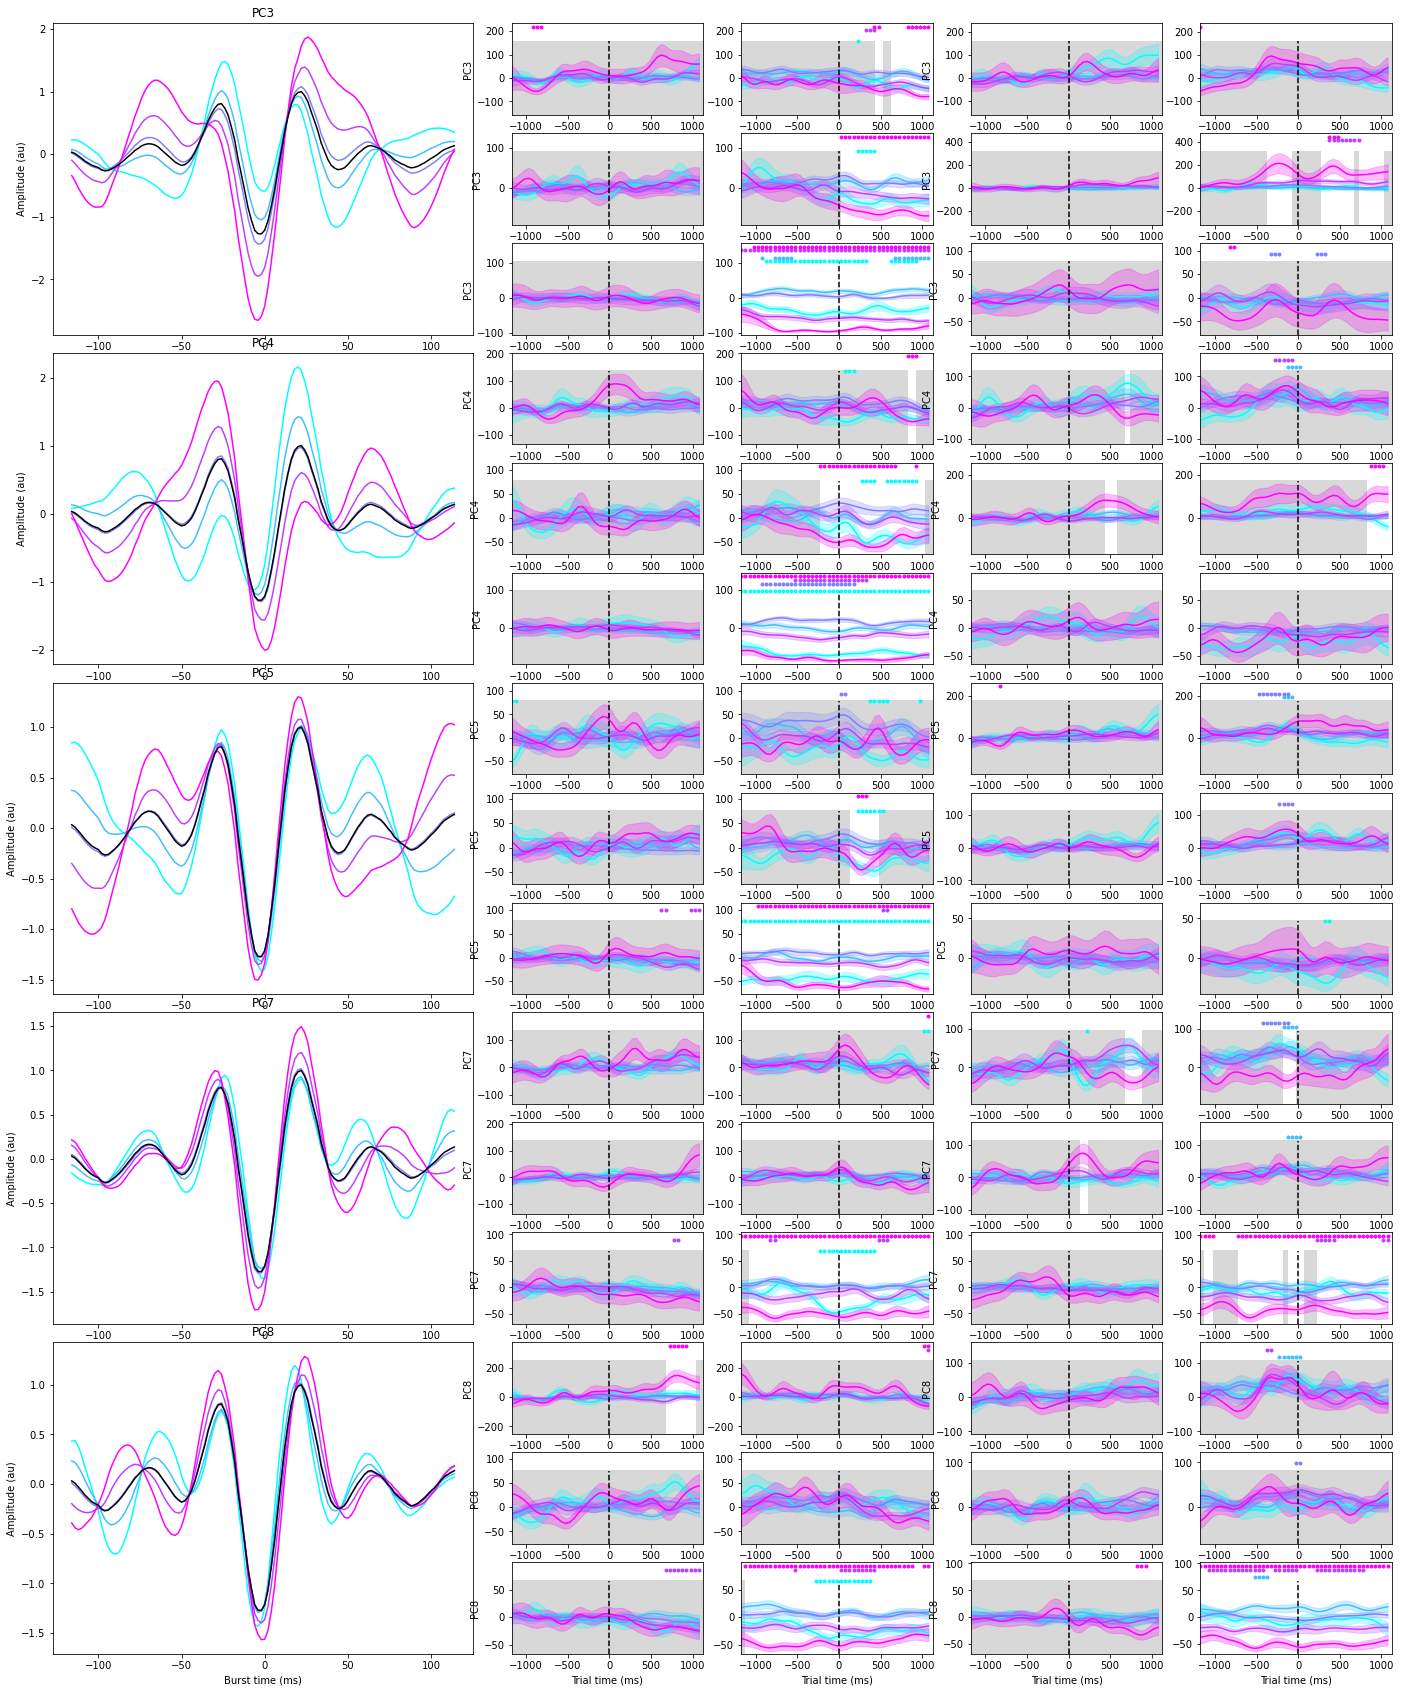

In [52]:
comps = [2,3,4,6,7]
n_comps=len(comps)

threshold_tfce = dict(start=0, step=0.01)
sigma = 1e-3
hat_corr = partial(ttest_1samp_no_p, sigma=sigma)

cool_colors = plt.cm.cool(np.linspace(0,1,5))        

age_bursts=[c_bursts_9m, c_bursts_12m, c_bursts_adult]
age_aligned_bursts=[aligned_c_9m_bursts, aligned_c_12m_bursts, aligned_c_adult_bursts]
age_burst_times=[c_burst_times_9m, c_burst_times_12m, c_burst_times_adult]
aligned_burst_times=c_burst_times_adult[:-1]

fig=plt.figure(figsize=(24,6*n_comps), facecolor='w')
gs = fig.add_gridspec(len(ages)*n_comps,2*2+2)

for comp_idx,comp in enumerate(comps):
    burst_metrics=[pca_components_c_9m.iloc[:,comp], 
                   pca_components_c_12m.iloc[:,comp], 
                   pca_components_c_adult.iloc[:,comp]]
    pc_comps=c_pca.components_[comp,:]

    ax = fig.add_subplot(gs[comp_idx*3+0:comp_idx*3+3, 0:2])
    m_lims = np.min(pcs_c[:,comp]), np.max(pcs_c[:,comp])
    group_bins=np.linspace(m_lims[0],m_lims[1],6)
    mean_burst=np.median(aligned_c_bursts,axis=0)
    norm_mean_burst=mean_burst/np.max(mean_burst)
    for m_idx in range(len(group_bins)-1):
        low_score = group_bins[m_idx]
        hi_score = group_bins[m_idx+1]
        m_bursts=(pcs_c[:,comp]>=low_score) & (pcs_c[:,comp]<=hi_score)
        val=norm_mean_burst+np.mean(burst_std_c[m_bursts,:],axis=0)
        ax.plot(aligned_burst_times,val,color=cool_colors[m_idx])
    ax.plot(aligned_burst_times,norm_mean_burst,'k')
    ax.set_xlabel('Burst time (ms)')
    ax.set_ylabel('Amplitude (au)')
    ax.set_title('PC{}'.format(comp+1))

    for age_idx, (bursts, aligned_bursts, burst_metric, burst_times) in enumerate(zip(age_bursts, age_aligned_bursts, burst_metrics, age_burst_times)):

        # Limits of metric
        m_lims = np.min(burst_metric), np.max(burst_metric)
        
        # Mean and normalized mean burst waveform
        mean_burst=np.mean(aligned_bursts,axis=0)
        norm_mean_burst=mean_burst/np.max(mean_burst)

        subjects=np.unique(bursts['subject'])                
        
        for cond_idx, condition in enumerate(['exe','obs']):
            
            ax1 = fig.add_subplot(gs[comp_idx*3+age_idx,2+cond_idx*2+0])
            ax2 = fig.add_subplot(gs[comp_idx*3+age_idx,2+cond_idx*2+1])

            (group_bins, base_bins, group_base_rate, exp_bins, group_exp_rate)=compute_group_rate(bursts, 
                                                                                                  condition,
                                                                                                  subjects,
                                                                                                  burst_metric, 
                                                                                                  m_lims)

            m_exps=[]
            m_bases=[]
            for m_idx in range(len(group_bins)-1):
                m_base=np.nanmean(group_base_rate[m_idx,:,:],axis=0)
                m_bases.append(group_base_rate[m_idx,:,:])
                m_exp=np.nanmean(group_exp_rate[m_idx,:,:],axis=0)
                m_exps.append(group_exp_rate[m_idx,:,:])

                se_base=np.nanstd(group_base_rate[m_idx,:,:],axis=0)/np.sqrt(len(subjects))
                ax1.fill_between(base_bins[:-1],m_base-se_base,m_base+se_base,color=cool_colors[m_idx],alpha=.25)
                ax1.plot(base_bins[:-1],m_base,color=cool_colors[m_idx])

                se_exp=np.nanstd(group_exp_rate[m_idx,:,:],axis=0)/np.sqrt(len(subjects))
                ax2.fill_between(exp_bins[:-1],m_exp-se_exp,m_exp+se_exp,color=cool_colors[m_idx],alpha=.25)
                ax2.plot(exp_bins[:-1],m_exp,color=cool_colors[m_idx])

            yl1=ax1.get_ylim()
            yl2=ax2.get_ylim()
            yl=[-np.max(np.abs(np.hstack([yl1,yl2]))), np.max(np.abs(np.hstack([yl1,yl2])))]
            ax1.plot([0, 0],[yl[0], yl[-1]],'k--')
            ax2.plot([0, 0],[yl[0], yl[-1]],'k--')
            
            pos_range=yl[1]
            for m_idx in range(len(group_bins)-1):
                mb_T_HAT, _, mb_P_HAT, _ = permutation_cluster_1samp_test(
                    group_base_rate[m_idx,:,:], stat_fun = hat_corr,
                    threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
                    out_type="mask", verbose=False, adjacency=None, buffer_size=None
                )
                for i in range(len(base_bins)-1):
                    if mb_P_HAT[i]<0.05:
                        ax1.plot(base_bins[i],yl[1]+m_idx*.1*pos_range, '.', color=cool_colors[m_idx])

                me_T_HAT, _, me_P_HAT, _ = permutation_cluster_1samp_test(
                    group_exp_rate[m_idx,:,:], stat_fun = hat_corr,
                    threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
                    out_type="mask", verbose=False, adjacency=None, buffer_size=None
                )
                for i in range(len(exp_bins)-1):
                    if me_P_HAT[i]<0.05:
                        ax2.plot(exp_bins[i],yl[1]+m_idx*.1*pos_range, '.',color=cool_colors[m_idx])

            new_yl=[yl[0], yl[1]+(len(group_bins)-1)*.1*pos_range]
            
            ax1.set_ylim(new_yl)
            ax2.set_ylim(new_yl)
            
            mb_T_HAT, _, mb_P_HAT, _ = permutation_cluster_test(m_bases, out_type='mask', n_permutations=1000,
                                                                threshold=threshold_tfce, tail=0, adjacency=None, 
                                                                verbose=False, n_jobs=-1)

            me_T_HAT, _, me_P_HAT, _ = permutation_cluster_test(m_exps, out_type='mask', n_permutations=1000, 
                                                                threshold=threshold_tfce, tail=0, adjacency=None, 
                                                                verbose=False, n_jobs=-1)

            mb_mask = np.zeros((100,mb_P_HAT.shape[0]))
            mb_mask[:,mb_P_HAT >= 0.05] = 1
            mb_mask[:,mb_P_HAT < 0.05] = np.nan

            me_mask = np.zeros((100,me_P_HAT.shape[0]))
            me_mask[:,me_P_HAT >= 0.05] = 1
            me_mask[:,me_P_HAT < 0.05] = np.nan

            graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)
            ax1.imshow(mb_mask,cmap="gray_r", origin="lower", norm=graynorm, 
                       extent=[base_bins[0], base_bins[-1], yl[0], yl[1]], 
                       aspect="auto", interpolation="none",alpha=0.3, rasterized=True)

            ax2.imshow(me_mask,cmap="gray_r", origin="lower", norm=graynorm, 
                       extent=[exp_bins[0], exp_bins[-1], yl[0], yl[1]], 
                       aspect="auto", interpolation="none",alpha=0.3, rasterized=True)


            ax1.set_ylabel('PC{}'.format(comp+1))
            ax1.set_xlabel('Trial time (ms)')
            ax2.set_xlabel('Trial time (ms)')
plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure5.svg')
plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure5.png')

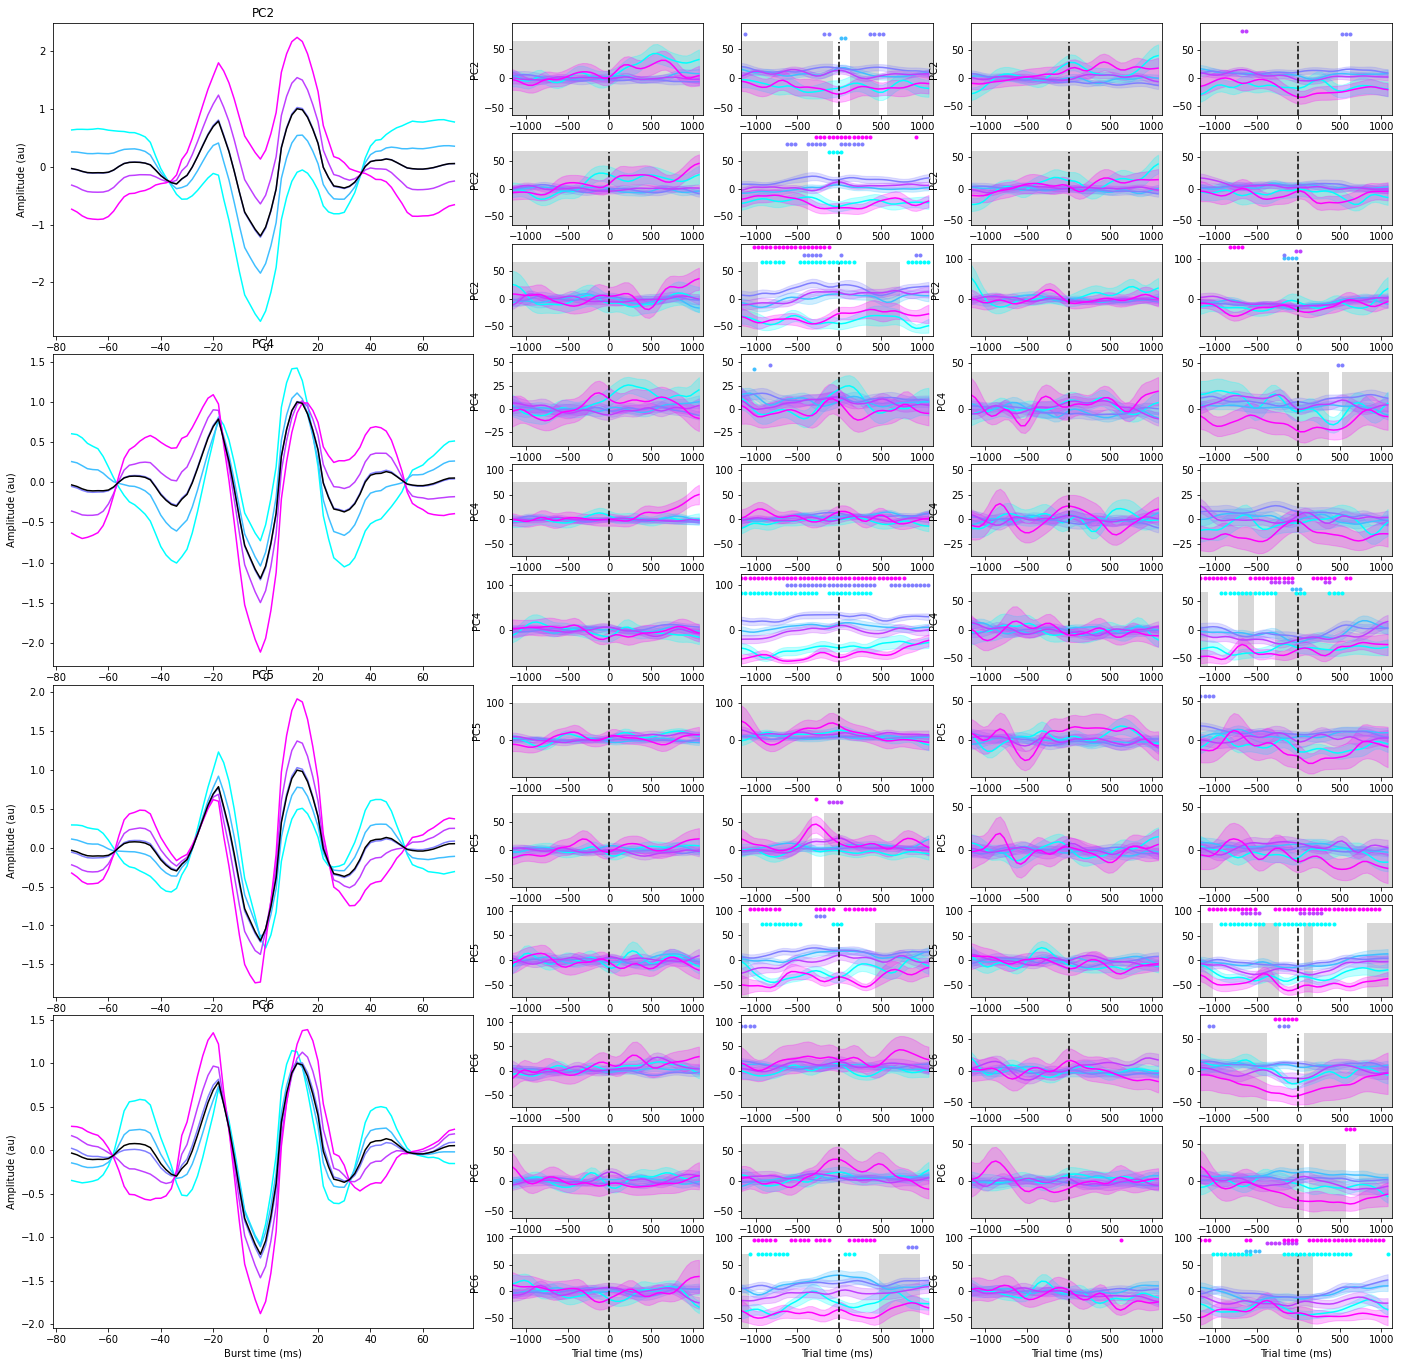

In [13]:
comps = [1,3,4,5]
n_comps=len(comps)

threshold_tfce = dict(start=0, step=0.01)
sigma = 1e-3
hat_corr = partial(ttest_1samp_no_p, sigma=sigma)

cool_colors = plt.cm.cool(np.linspace(0,1,5))        

age_bursts=[p_bursts_9m, p_bursts_12m, p_bursts_adult]
age_aligned_bursts=[aligned_p_9m_bursts, aligned_p_12m_bursts, aligned_p_adult_bursts]
age_burst_times=[p_burst_times_9m, p_burst_times_12m, p_burst_times_adult]
aligned_burst_times=p_burst_times_adult[:-1]

fig=plt.figure(figsize=(24,6*n_comps), facecolor='w')
gs = fig.add_gridspec(len(ages)*n_comps,2*2+2)

for comp_idx,comp in enumerate(comps):    
    burst_metrics=[pca_components_p_9m.iloc[:,comp], 
                   pca_components_p_12m.iloc[:,comp], 
                   pca_components_p_adult.iloc[:,comp]]
    pc_comps=p_pca.components_[comp,:]

    ax = fig.add_subplot(gs[comp_idx*3+0:comp_idx*3+3, 0:2])
    m_lims = np.min(pcs_p[:,comp]), np.max(pcs_p[:,comp])
    group_bins=np.linspace(m_lims[0],m_lims[1],6)
    mean_burst=np.median(aligned_p_bursts,axis=0)
    norm_mean_burst=mean_burst/np.max(mean_burst)
    for m_idx in range(len(group_bins)-1):
        low_score = group_bins[m_idx]
        hi_score = group_bins[m_idx+1]
        m_bursts=(pcs_p[:,comp]>=low_score) & (pcs_p[:,comp]<=hi_score)
        val=norm_mean_burst+np.mean(burst_std_p[m_bursts,:],axis=0)
        ax.plot(aligned_burst_times,val,color=cool_colors[m_idx])
    ax.plot(aligned_burst_times,norm_mean_burst,'k')
    ax.set_xlabel('Burst time (ms)')
    ax.set_ylabel('Amplitude (au)')
    ax.set_title('PC{}'.format(comp+1))

    for age_idx, (bursts, aligned_bursts, burst_metric, burst_times) in enumerate(zip(age_bursts, age_aligned_bursts, burst_metrics, age_burst_times)):

        # Limits of metric
        m_lims = np.min(burst_metric), np.max(burst_metric)
        
        # Mean and normalized mean burst waveform
        mean_burst=np.mean(aligned_bursts,axis=0)
        norm_mean_burst=mean_burst/np.max(mean_burst)

        subjects=np.unique(bursts['subject'])                
        
        for cond_idx, condition in enumerate(['exe','obs']):

            ax1 = fig.add_subplot(gs[comp_idx*3+age_idx,2+cond_idx*2+0])
            ax2 = fig.add_subplot(gs[comp_idx*3+age_idx,2+cond_idx*2+1])

            (group_bins, base_bins, group_base_rate, exp_bins, group_exp_rate)=compute_group_rate(bursts, 
                                                                                                  condition,
                                                                                                  subjects,
                                                                                                  burst_metric, 
                                                                                                  m_lims)

            m_exps=[]
            m_bases=[]
            for m_idx in range(len(group_bins)-1):
                m_base=np.nanmean(group_base_rate[m_idx,:,:],axis=0)
                m_bases.append(group_base_rate[m_idx,:,:])
                m_exp=np.nanmean(group_exp_rate[m_idx,:,:],axis=0)
                m_exps.append(group_exp_rate[m_idx,:,:])

                se_base=np.nanstd(group_base_rate[m_idx,:,:],axis=0)/np.sqrt(len(subjects))
                ax1.fill_between(base_bins[:-1],m_base-se_base,m_base+se_base,color=cool_colors[m_idx],alpha=.25)
                ax1.plot(base_bins[:-1],m_base,color=cool_colors[m_idx])

                se_exp=np.nanstd(group_exp_rate[m_idx,:,:],axis=0)/np.sqrt(len(subjects))
                ax2.fill_between(exp_bins[:-1],m_exp-se_exp,m_exp+se_exp,color=cool_colors[m_idx],alpha=.25)
                ax2.plot(exp_bins[:-1],m_exp,color=cool_colors[m_idx])

            yl1=ax1.get_ylim()
            yl2=ax2.get_ylim()
            yl=[-np.max(np.abs(np.hstack([yl1,yl2]))), np.max(np.abs(np.hstack([yl1,yl2])))]
            ax1.plot([0, 0],[yl[0], yl[-1]],'k--')
            ax2.plot([0, 0],[yl[0], yl[-1]],'k--')
            
            pos_range=yl[1]
            for m_idx in range(len(group_bins)-1):
                mb_T_HAT, _, mb_P_HAT, _ = permutation_cluster_1samp_test(
                    group_base_rate[m_idx,:,:], stat_fun = hat_corr,
                    threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
                    out_type="mask", verbose=False, adjacency=None, buffer_size=None
                )
                for i in range(len(base_bins)-1):
                    if mb_P_HAT[i]<0.05:
                        ax1.plot(base_bins[i],yl[1]+m_idx*.1*pos_range, '.', color=cool_colors[m_idx])

                me_T_HAT, _, me_P_HAT, _ = permutation_cluster_1samp_test(
                    group_exp_rate[m_idx,:,:], stat_fun = hat_corr,
                    threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
                    out_type="mask", verbose=False, adjacency=None, buffer_size=None
                )
                for i in range(len(exp_bins)-1):
                    if me_P_HAT[i]<0.05:
                        ax2.plot(exp_bins[i],yl[1]+m_idx*.1*pos_range, '.',color=cool_colors[m_idx])

            new_yl=[yl[0], yl[1]+(len(group_bins)-1)*.1*pos_range]
            
            ax1.set_ylim(new_yl)
            ax2.set_ylim(new_yl)
            
            mb_T_HAT, _, mb_P_HAT, _ = permutation_cluster_test(m_bases, out_type='mask', n_permutations=1000,
                                                                threshold=threshold_tfce, tail=0, adjacency=None, 
                                                                verbose=False, n_jobs=-1)

            me_T_HAT, _, me_P_HAT, _ = permutation_cluster_test(m_exps, out_type='mask', n_permutations=1000, 
                                                                threshold=threshold_tfce, tail=0, adjacency=None, 
                                                                verbose=False, n_jobs=-1)

            mb_mask = np.zeros((100,mb_P_HAT.shape[0]))
            mb_mask[:,mb_P_HAT >= 0.05] = 1
            mb_mask[:,mb_P_HAT < 0.05] = np.nan

            me_mask = np.zeros((100,me_P_HAT.shape[0]))
            me_mask[:,me_P_HAT >= 0.05] = 1
            me_mask[:,me_P_HAT < 0.05] = np.nan

            graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)
            ax1.imshow(mb_mask,cmap="gray_r", origin="lower", norm=graynorm, 
                       extent=[base_bins[0], base_bins[-1], yl[0], yl[1]], 
                       aspect="auto", interpolation="none",alpha=0.3, rasterized=True)

            ax2.imshow(me_mask,cmap="gray_r", origin="lower", norm=graynorm, 
                       extent=[exp_bins[0], exp_bins[-1], yl[0], yl[1]], 
                       aspect="auto", interpolation="none",alpha=0.3, rasterized=True)


            ax1.set_ylabel('PC{}'.format(comp+1))
            ax1.set_xlabel('Trial time (ms)')
            ax2.set_xlabel('Trial time (ms)')
plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure6.svg')
plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure6.png')

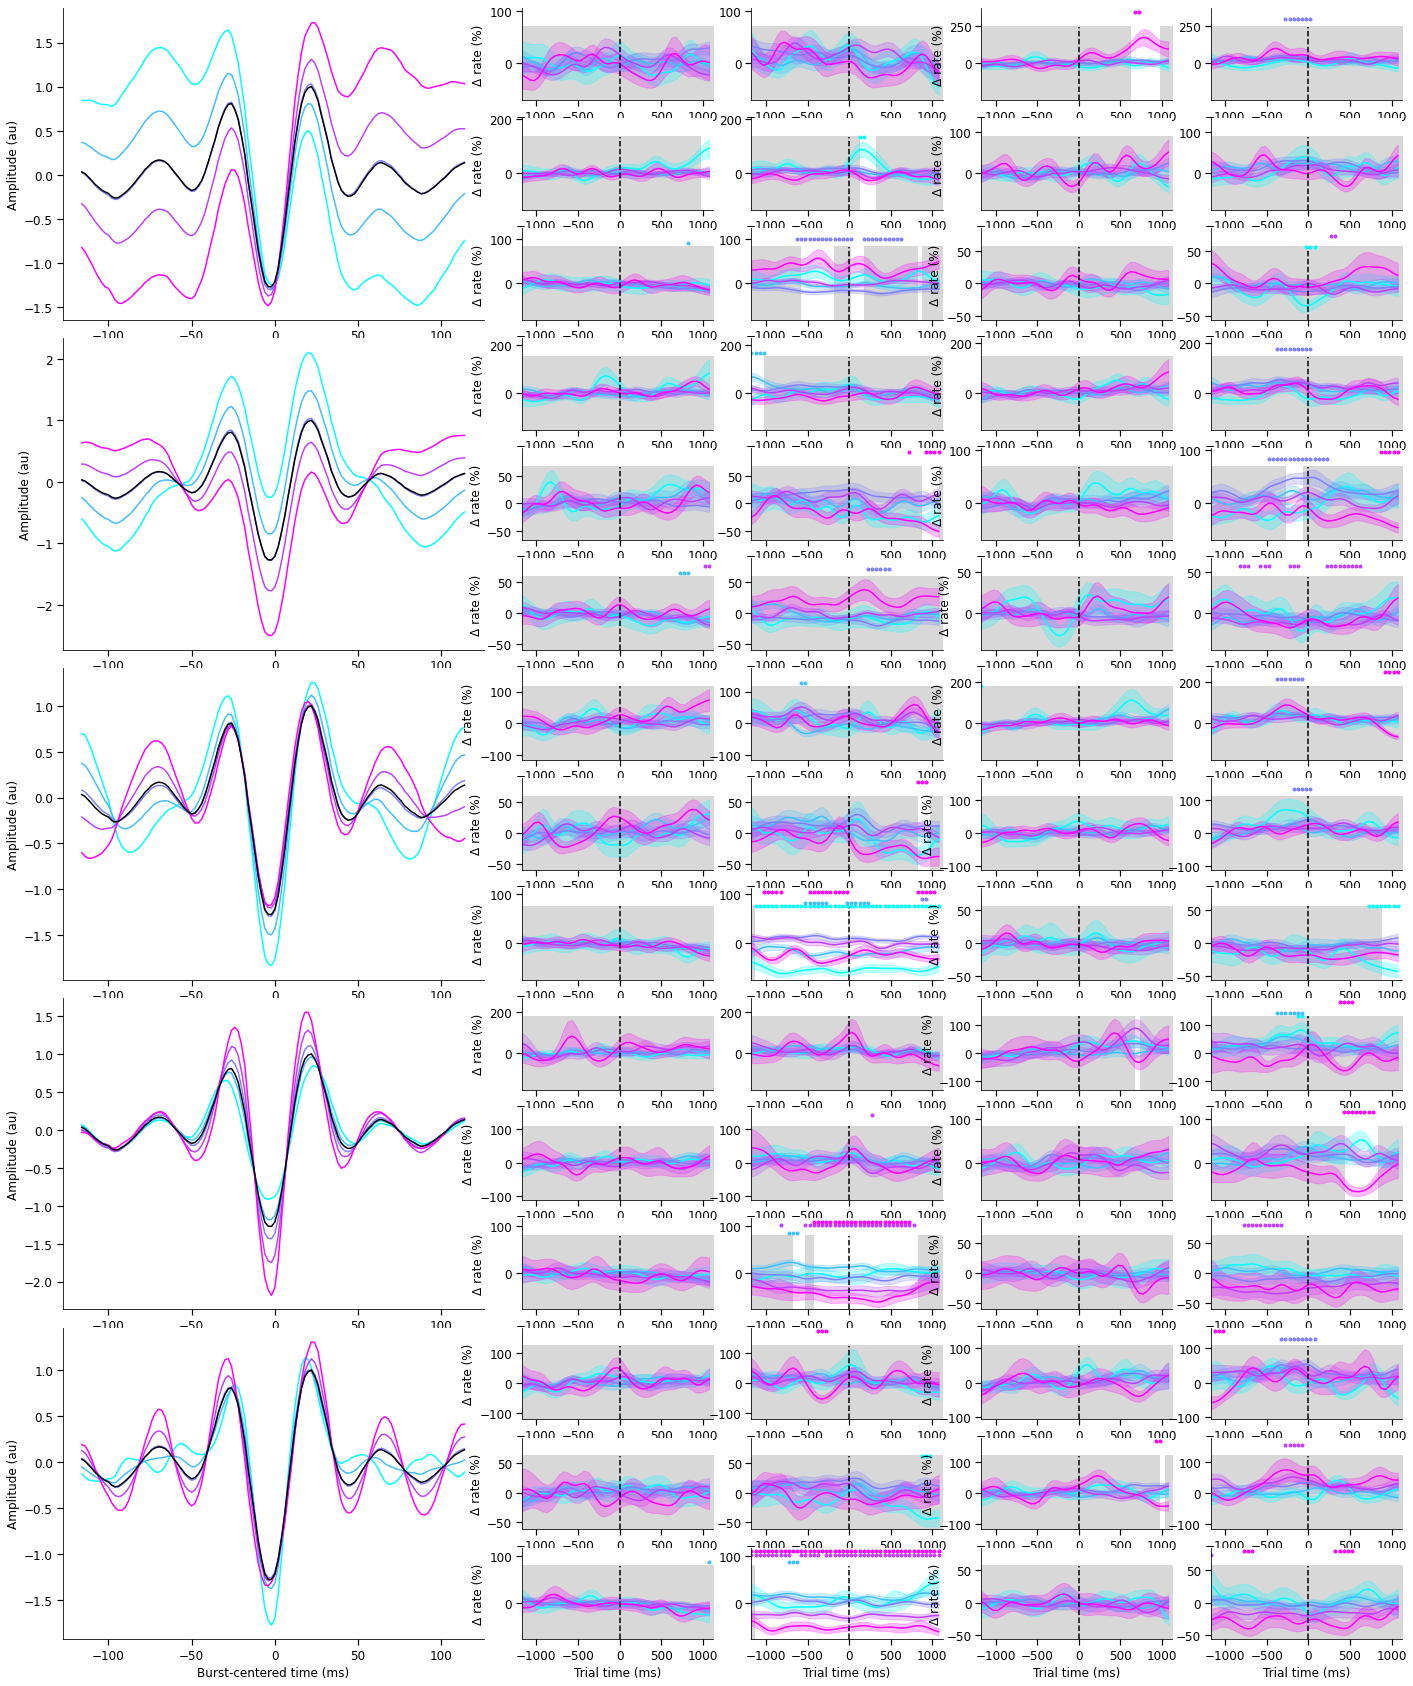

In [63]:
plt.rcParams.update({
    'font.size': 12,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

comps = [0,1,5,8,9]
n_comps=len(comps)

threshold_tfce = dict(start=0, step=0.01)
sigma = 1e-3
hat_corr = partial(ttest_1samp_no_p, sigma=sigma)

cool_colors = plt.cm.cool(np.linspace(0,1,5))        

age_bursts=[c_bursts_9m, c_bursts_12m, c_bursts_adult]
age_aligned_bursts=[aligned_c_9m_bursts, aligned_c_12m_bursts, aligned_c_adult_bursts]
age_burst_times=[c_burst_times_9m, c_burst_times_12m, c_burst_times_adult]
aligned_burst_times=c_burst_times_adult[:-1]

fig=plt.figure(figsize=(24,6*n_comps), facecolor='w')
gs = fig.add_gridspec(len(ages)*n_comps,2*2+2)

for comp_idx,comp in enumerate(comps):
    
    burst_metrics=[pca_components_c_9m.iloc[:,comp], 
                   pca_components_c_12m.iloc[:,comp], 
                   pca_components_c_adult.iloc[:,comp]]
    pc_comps=c_pca.components_[comp,:]

    ax = fig.add_subplot(gs[comp_idx*3+0:comp_idx*3+3, 0:2])
    m_lims = np.min(pcs_c[:,comp]), np.max(pcs_c[:,comp])
    group_bins=np.linspace(m_lims[0],m_lims[1],6)
    mean_burst=np.median(aligned_c_bursts,axis=0)
    norm_mean_burst=mean_burst/np.max(mean_burst)
    for m_idx in range(len(group_bins)-1):
        low_score = group_bins[m_idx]
        hi_score = group_bins[m_idx+1]
        m_bursts=(pcs_c[:,comp]>=low_score) & (pcs_c[:,comp]<=hi_score)
        val=norm_mean_burst+np.mean(burst_std_c[m_bursts,:],axis=0)
        ax.plot(aligned_burst_times,val,color=cool_colors[m_idx])
    ax.plot(aligned_burst_times,norm_mean_burst,'k')
    ax.set_xlabel('Burst-centered time (ms)')
    ax.set_ylabel('Amplitude (au)')

    for age_idx, (bursts, aligned_bursts, burst_metric, burst_times) in enumerate(zip(age_bursts, age_aligned_bursts, burst_metrics, age_burst_times)):

        # Limits of metric
        m_lims = np.min(burst_metric), np.max(burst_metric)
        
        # Mean and normalized mean burst waveform
        mean_burst=np.mean(aligned_bursts,axis=0)
        norm_mean_burst=mean_burst/np.max(mean_burst)

        subjects=np.unique(bursts['subject'])                
        
        for cond_idx, condition in enumerate(['exe','obs']):

            ax1 = fig.add_subplot(gs[comp_idx*3+age_idx,2+cond_idx*2+0])
            ax2 = fig.add_subplot(gs[comp_idx*3+age_idx,2+cond_idx*2+1])

            (group_bins, base_bins, group_base_rate, exp_bins, group_exp_rate)=compute_group_rate(bursts, 
                                                                                                  condition,
                                                                                                  subjects,
                                                                                                  burst_metric, 
                                                                                                  m_lims)

            m_exps=[]
            m_bases=[]
            for m_idx in range(len(group_bins)-1):
                m_base=np.nanmean(group_base_rate[m_idx,:,:],axis=0)
                m_bases.append(group_base_rate[m_idx,:,:])
                m_exp=np.nanmean(group_exp_rate[m_idx,:,:],axis=0)
                m_exps.append(group_exp_rate[m_idx,:,:])

                se_base=np.nanstd(group_base_rate[m_idx,:,:],axis=0)/np.sqrt(len(subjects))
                ax1.fill_between(base_bins[:-1],m_base-se_base,m_base+se_base,color=cool_colors[m_idx],alpha=.25)
                ax1.plot(base_bins[:-1],m_base,color=cool_colors[m_idx])

                se_exp=np.nanstd(group_exp_rate[m_idx,:,:],axis=0)/np.sqrt(len(subjects))
                ax2.fill_between(exp_bins[:-1],m_exp-se_exp,m_exp+se_exp,color=cool_colors[m_idx],alpha=.25)
                ax2.plot(exp_bins[:-1],m_exp,color=cool_colors[m_idx])

            yl1=ax1.get_ylim()
            yl2=ax2.get_ylim()
            yl=[-np.max(np.abs(np.hstack([yl1,yl2]))), np.max(np.abs(np.hstack([yl1,yl2])))]
            ax1.plot([0, 0],[yl[0], yl[-1]],'k--')
            ax2.plot([0, 0],[yl[0], yl[-1]],'k--')
            
            pos_range=yl[1]
            for m_idx in range(len(group_bins)-1):
                mb_T_HAT, _, mb_P_HAT, _ = permutation_cluster_1samp_test(
                    group_base_rate[m_idx,:,:], stat_fun = hat_corr,
                    threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
                    out_type="mask", verbose=False, adjacency=None, buffer_size=None
                )
                for i in range(len(base_bins)-1):
                    if mb_P_HAT[i]<0.05:
                        ax1.plot(base_bins[i],yl[1]+m_idx*.1*pos_range, '.', color=cool_colors[m_idx])

                me_T_HAT, _, me_P_HAT, _ = permutation_cluster_1samp_test(
                    group_exp_rate[m_idx,:,:], stat_fun = hat_corr,
                    threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
                    out_type="mask", verbose=False, adjacency=None, buffer_size=None
                )
                for i in range(len(exp_bins)-1):
                    if me_P_HAT[i]<0.05:
                        ax2.plot(exp_bins[i],yl[1]+m_idx*.1*pos_range, '.',color=cool_colors[m_idx])

            new_yl=[yl[0], yl[1]+(len(group_bins)-1)*.1*pos_range]
            
            ax1.set_ylim(new_yl)
            ax2.set_ylim(new_yl)
            
            mb_T_HAT, _, mb_P_HAT, _ = permutation_cluster_test(m_bases, out_type='mask', n_permutations=1000,
                                                                threshold=threshold_tfce, tail=0, adjacency=None, 
                                                                verbose=False, n_jobs=-1)

            me_T_HAT, _, me_P_HAT, _ = permutation_cluster_test(m_exps, out_type='mask', n_permutations=1000, 
                                                                threshold=threshold_tfce, tail=0, adjacency=None, 
                                                                verbose=False, n_jobs=-1)

            mb_mask = np.zeros((100,mb_P_HAT.shape[0]))
            mb_mask[:,mb_P_HAT >= 0.05] = 1
            mb_mask[:,mb_P_HAT < 0.05] = np.nan

            me_mask = np.zeros((100,me_P_HAT.shape[0]))
            me_mask[:,me_P_HAT >= 0.05] = 1
            me_mask[:,me_P_HAT < 0.05] = np.nan

            graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)
            ax1.imshow(mb_mask,cmap="gray_r", origin="lower", norm=graynorm, 
                       extent=[base_bins[0], base_bins[-1], yl[0], yl[1]], 
                       aspect="auto", interpolation="none",alpha=0.3, rasterized=True)

            ax2.imshow(me_mask,cmap="gray_r", origin="lower", norm=graynorm, 
                       extent=[exp_bins[0], exp_bins[-1], yl[0], yl[1]], 
                       aspect="auto", interpolation="none",alpha=0.3, rasterized=True)


            ax1.set_ylabel('Δ rate (%)')
            if age_idx==len(ages)-1:
                ax1.set_xlabel('Trial time (ms)')
                ax2.set_xlabel('Trial time (ms)')
#plt.tight_layout()
plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure_s5.svg')
plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure_s5.png')

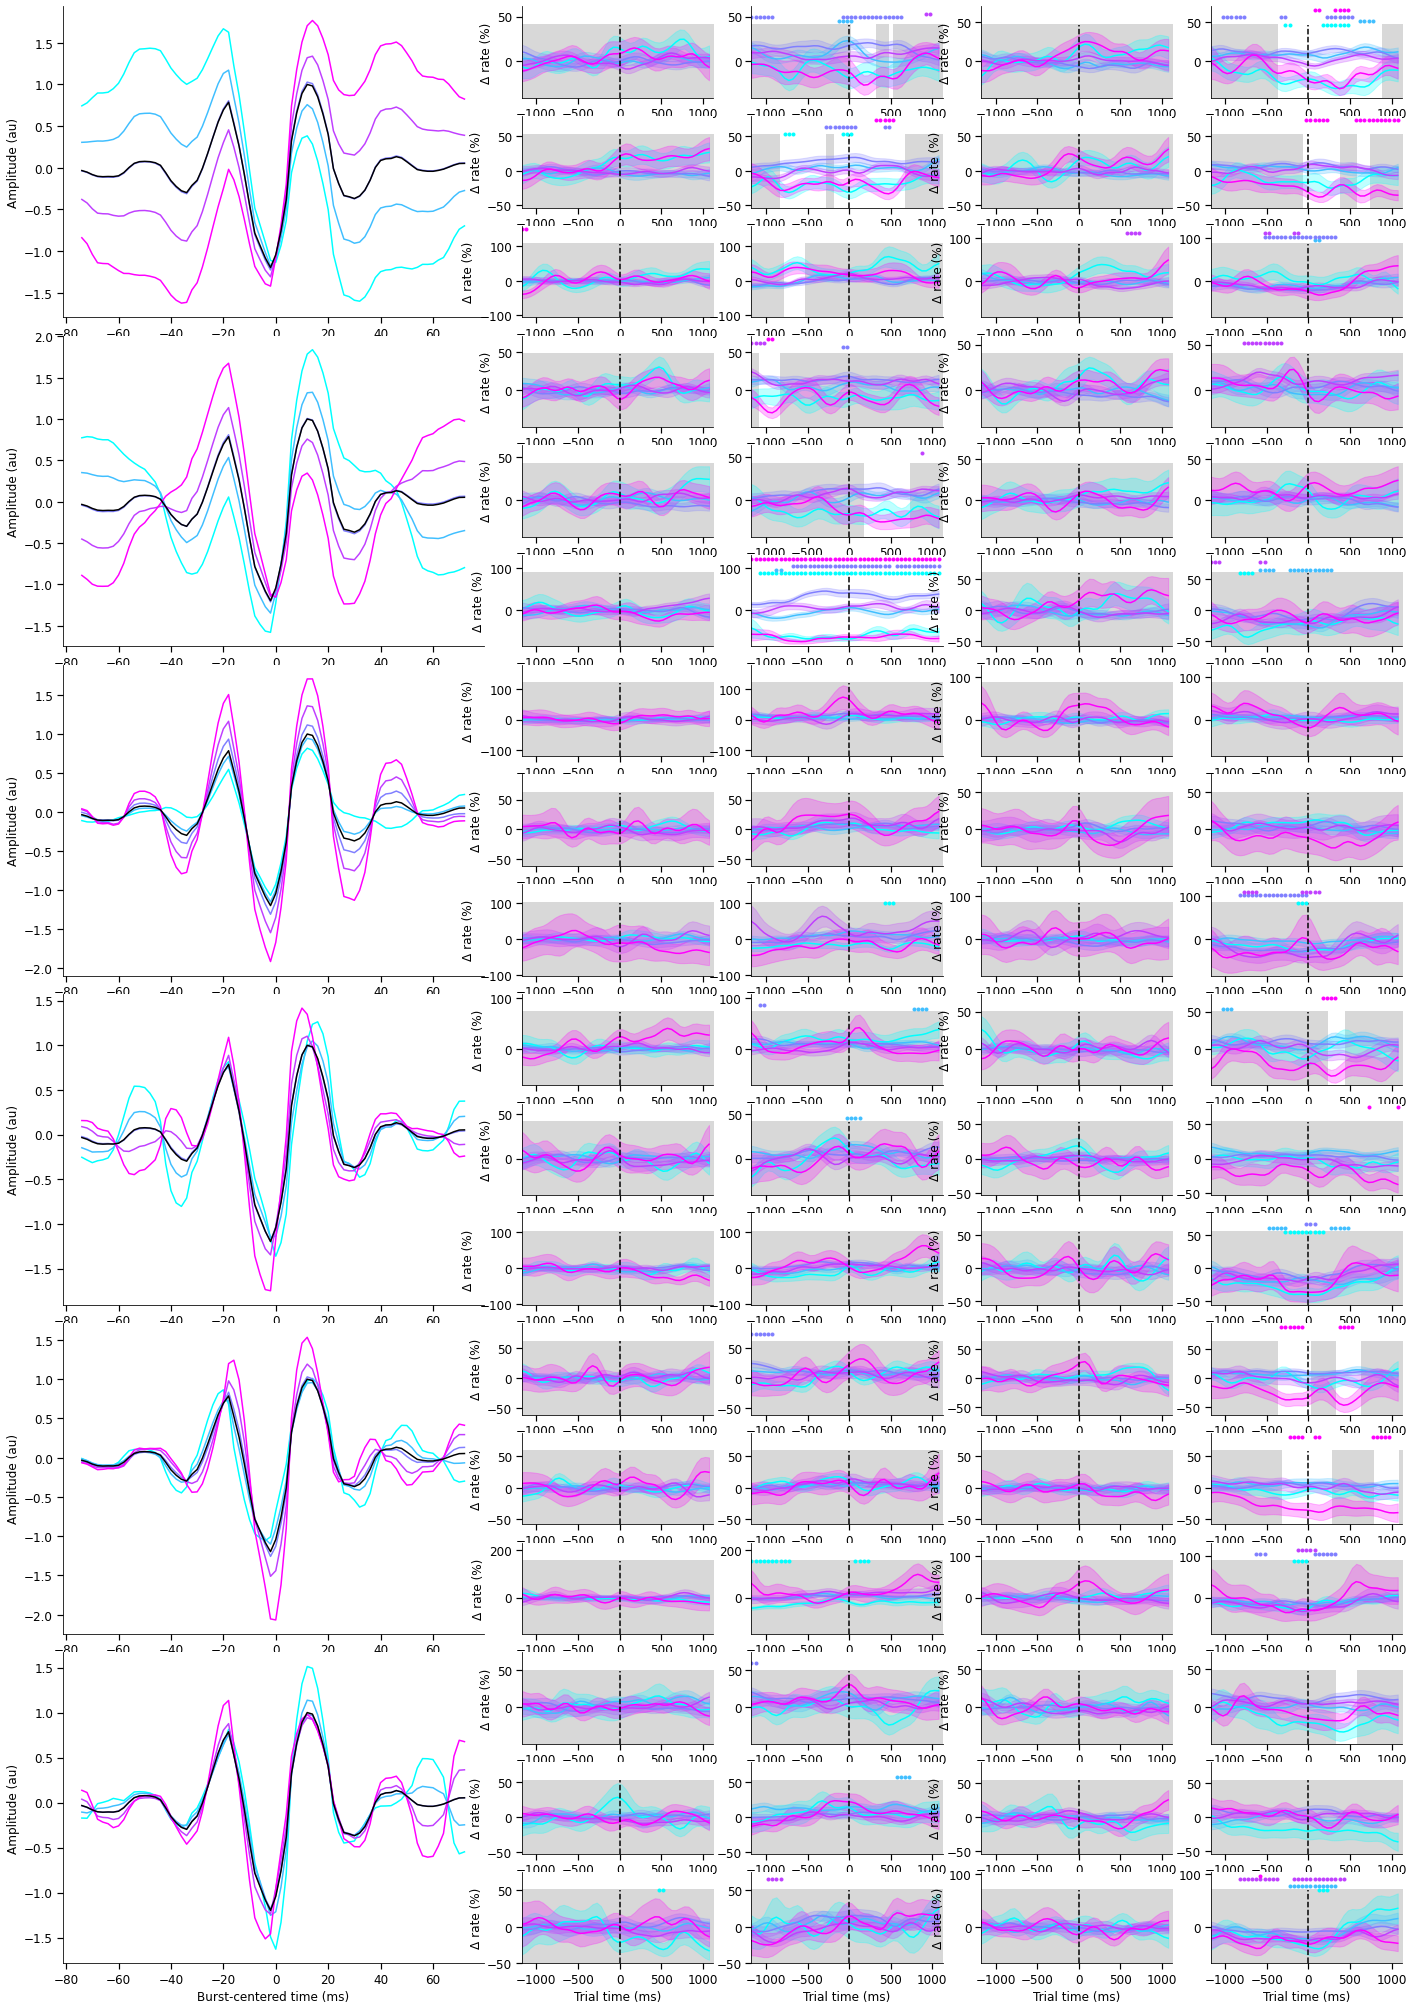

In [14]:
plt.rcParams.update({
    'font.size': 12,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})
comps = [0,2,6,7,8,9]
n_comps=len(comps)

threshold_tfce = dict(start=0, step=0.01)
sigma = 1e-3
hat_corr = partial(ttest_1samp_no_p, sigma=sigma)

cool_colors = plt.cm.cool(np.linspace(0,1,5))        

age_bursts=[p_bursts_9m, p_bursts_12m, p_bursts_adult]
age_aligned_bursts=[aligned_p_9m_bursts, aligned_p_12m_bursts, aligned_p_adult_bursts]
age_burst_times=[p_burst_times_9m, p_burst_times_12m, p_burst_times_adult]
aligned_burst_times=p_burst_times_adult[:-1]

fig=plt.figure(figsize=(24,6*n_comps), facecolor='w')
gs = fig.add_gridspec(len(ages)*n_comps,2*2+2)

for comp_idx,comp in enumerate(comps):
    
    burst_metrics=[pca_components_p_9m.iloc[:,comp], 
                   pca_components_p_12m.iloc[:,comp], 
                   pca_components_p_adult.iloc[:,comp]]
    pc_comps=p_pca.components_[comp,:]

    ax = fig.add_subplot(gs[comp_idx*3+0:comp_idx*3+3, 0:2])
    m_lims = np.min(pcs_p[:,comp]), np.max(pcs_p[:,comp])
    group_bins=np.linspace(m_lims[0],m_lims[1],6)
    mean_burst=np.median(aligned_p_bursts,axis=0)
    norm_mean_burst=mean_burst/np.max(mean_burst)
    for m_idx in range(len(group_bins)-1):
        low_score = group_bins[m_idx]
        hi_score = group_bins[m_idx+1]
        m_bursts=(pcs_p[:,comp]>=low_score) & (pcs_p[:,comp]<=hi_score)
        val=norm_mean_burst+np.mean(burst_std_p[m_bursts,:],axis=0)
        ax.plot(aligned_burst_times,val,color=cool_colors[m_idx])
    ax.plot(aligned_burst_times,norm_mean_burst,'k')
    ax.set_xlabel('Burst-centered time (ms)')
    ax.set_ylabel('Amplitude (au)')

    for age_idx, (bursts, aligned_bursts, burst_metric, burst_times) in enumerate(zip(age_bursts, age_aligned_bursts, burst_metrics, age_burst_times)):

        # Limits of metric
        m_lims = np.min(burst_metric), np.max(burst_metric)
        
        # Mean and normalized mean burst waveform
        mean_burst=np.mean(aligned_bursts,axis=0)
        norm_mean_burst=mean_burst/np.max(mean_burst)

        subjects=np.unique(bursts['subject'])                
        
        for cond_idx, condition in enumerate(['exe','obs']):

            ax1 = fig.add_subplot(gs[comp_idx*3+age_idx,2+cond_idx*2+0])
            ax2 = fig.add_subplot(gs[comp_idx*3+age_idx,2+cond_idx*2+1])

            (group_bins, base_bins, group_base_rate, exp_bins, group_exp_rate)=compute_group_rate(bursts, 
                                                                                                  condition,
                                                                                                  subjects,
                                                                                                  burst_metric, 
                                                                                                  m_lims)

            m_exps=[]
            m_bases=[]
            for m_idx in range(len(group_bins)-1):
                m_base=np.nanmean(group_base_rate[m_idx,:,:],axis=0)
                m_bases.append(group_base_rate[m_idx,:,:])
                m_exp=np.nanmean(group_exp_rate[m_idx,:,:],axis=0)
                m_exps.append(group_exp_rate[m_idx,:,:])

                se_base=np.nanstd(group_base_rate[m_idx,:,:],axis=0)/np.sqrt(len(subjects))
                ax1.fill_between(base_bins[:-1],m_base-se_base,m_base+se_base,color=cool_colors[m_idx],alpha=.25)
                ax1.plot(base_bins[:-1],m_base,color=cool_colors[m_idx])

                se_exp=np.nanstd(group_exp_rate[m_idx,:,:],axis=0)/np.sqrt(len(subjects))
                ax2.fill_between(exp_bins[:-1],m_exp-se_exp,m_exp+se_exp,color=cool_colors[m_idx],alpha=.25)
                ax2.plot(exp_bins[:-1],m_exp,color=cool_colors[m_idx])

            yl1=ax1.get_ylim()
            yl2=ax2.get_ylim()
            yl=[-np.max(np.abs(np.hstack([yl1,yl2]))), np.max(np.abs(np.hstack([yl1,yl2])))]
            ax1.plot([0, 0],[yl[0], yl[-1]],'k--')
            ax2.plot([0, 0],[yl[0], yl[-1]],'k--')
            
            pos_range=yl[1]
            for m_idx in range(len(group_bins)-1):
                mb_T_HAT, _, mb_P_HAT, _ = permutation_cluster_1samp_test(
                    group_base_rate[m_idx,:,:], stat_fun = hat_corr,
                    threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
                    out_type="mask", verbose=False, adjacency=None, buffer_size=None
                )
                for i in range(len(base_bins)-1):
                    if mb_P_HAT[i]<0.05:
                        ax1.plot(base_bins[i],yl[1]+m_idx*.1*pos_range, '.', color=cool_colors[m_idx])

                me_T_HAT, _, me_P_HAT, _ = permutation_cluster_1samp_test(
                    group_exp_rate[m_idx,:,:], stat_fun = hat_corr,
                    threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
                    out_type="mask", verbose=False, adjacency=None, buffer_size=None
                )
                for i in range(len(exp_bins)-1):
                    if me_P_HAT[i]<0.05:
                        ax2.plot(exp_bins[i],yl[1]+m_idx*.1*pos_range, '.',color=cool_colors[m_idx])

            new_yl=[yl[0], yl[1]+(len(group_bins)-1)*.1*pos_range]
            
            ax1.set_ylim(new_yl)
            ax2.set_ylim(new_yl)
            
            mb_T_HAT, _, mb_P_HAT, _ = permutation_cluster_test(m_bases, out_type='mask', n_permutations=1000,
                                                                threshold=threshold_tfce, tail=0, adjacency=None, 
                                                                verbose=False, n_jobs=-1)

            me_T_HAT, _, me_P_HAT, _ = permutation_cluster_test(m_exps, out_type='mask', n_permutations=1000, 
                                                                threshold=threshold_tfce, tail=0, adjacency=None, 
                                                                verbose=False, n_jobs=-1)

            mb_mask = np.zeros((100,mb_P_HAT.shape[0]))
            mb_mask[:,mb_P_HAT >= 0.05] = 1
            mb_mask[:,mb_P_HAT < 0.05] = np.nan

            me_mask = np.zeros((100,me_P_HAT.shape[0]))
            me_mask[:,me_P_HAT >= 0.05] = 1
            me_mask[:,me_P_HAT < 0.05] = np.nan

            graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)
            ax1.imshow(mb_mask,cmap="gray_r", origin="lower", norm=graynorm, 
                       extent=[base_bins[0], base_bins[-1], yl[0], yl[1]], 
                       aspect="auto", interpolation="none",alpha=0.3, rasterized=True)

            ax2.imshow(me_mask,cmap="gray_r", origin="lower", norm=graynorm, 
                       extent=[exp_bins[0], exp_bins[-1], yl[0], yl[1]], 
                       aspect="auto", interpolation="none",alpha=0.3, rasterized=True)


            ax1.set_ylabel('Δ rate (%)')
            if age_idx==len(ages)-1:
                ax1.set_xlabel('Trial time (ms)')
                ax2.set_xlabel('Trial time (ms)')
#plt.tight_layout()
plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure_s6.svg')
plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure_s6.png')